<a href="https://colab.research.google.com/github/OlgaShevel/Non-Computer-Vision-Project/blob/main/!ak_TextClassifier(AutoKeras)_%2B_Translator_(Google).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Решила сравнить точность текстового классификатора AutoKeras при распознании одних и тех же фраз на оригинальном английском языке и на автопереводе на русский язык, сделанный Translator от Google.

In [ ]:
!pip install googletrans==3.1.0a0

In [ ]:
!pip -q uninstall -y pyarrow
!pip -q uninstall -y pydantic
!pip -q install pydantic==1.10.13
!pip -q install autokeras==1.0.20
!pip -q install terra-ai-datasets-framework

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import random
import tensorflow as tf
from googletrans import Translator
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import autokeras as ak


В датасете представлены сообщения из твиттера (на англ. языке).

Твитты разделены на два класса:
- о происшествиях и различных событиях, которые не связаны со стихийными бедствиями (класс 0)
- о стихийных бедствиях, природных катаклизмах и т.д (класс 1)

**Загрузить датасет**

In [ ]:
!git clone https://github.com/tkeldenich/AutoKeras_BinaryClassification_DisasterTweet.git
%cd AutoKeras_BinaryClassification_DisasterTweet

for file in glob.glob('*.ipynb') + glob.glob('Readme.md'):
    os.remove(file)

Cloning into 'AutoKeras_BinaryClassification_DisasterTweet'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 30 (delta 15), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (30/30), 593.59 KiB | 2.26 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/AutoKeras_BinaryClassification_DisasterTweet


In [ ]:
train_df = pd.read_csv('/content/AutoKeras_BinaryClassification_DisasterTweet/train.csv')
test_df = pd.read_csv('/content/AutoKeras_BinaryClassification_DisasterTweet/test.csv')

In [ ]:
train_df.head(100)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
95,137,accident,Charlotte,9 Mile backup on I-77 South...accident blockin...,1
96,138,accident,"Baton Rouge, LA",Has an accident changed your life? We will hel...,0
97,139,accident,"Hagerstown, MD",#BREAKING: there was a deadly motorcycle car a...,1
98,141,accident,"Gloucestershire , UK",@flowri were you marinading it or was it an ac...,0


In [ ]:
x_train = train_df['text'].to_numpy()
y_train = train_df['target'].to_numpy()
x_test = test_df['text'].to_numpy()
y_test = test_df['id'].to_numpy()

print(x_train.size, x_train.shape)
print(y_train.size, y_train.shape)
print(x_test.size, x_test.shape)
print(y_test.size, y_test.shape)

7613 (7613,)
7613 (7613,)
3263 (3263,)
3263 (3263,)


In [ ]:
y_train = y_train.astype(np.int8)
print(y_train)

[1 1 1 ... 1 1 1]


In [ ]:
# уменьшим обучающую выборку до 1000 фраз

'''
n_samples = 1000

# Выбираем случайные индексы для обрезки
indices = np.random.choice(x_train.shape[0], n_samples, replace=False)
x_train_cut = x_train[indices]
y_train_cut = y_train[indices]

print(x_train_cut.size, x_train_cut.shape)
print(y_train_cut.size, y_train_cut.shape)
'''

1000 (1000,)
1000 (1000,)


**Подготовим данные для подачи в классификатор AutoKeras на английском языке**


---



In [ ]:
# Расставим запятые между фразами и сделаем кавычки однотипно двойными
# здесь массив сохраняем как numpy

x_train1 = np.array([x.replace(', ', ',') for x in x_train])
x_train2 = np.array([s.replace("'", '"') for s in x_train1])
x_train2[:10]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       'All residents asked to "shelter in place" are being notified by officers. No other evacuation or shelter in place orders are expected',
       '13,000 people receive #wildfires evacuation orders in California ',
       'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
       '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
       '#flood #disaster Heavy rain causes flash flooding of streets in Manitou,Colorado Springs areas',
       'I"m on top of the hill and I can see a fire in the woods...',
       'There"s an emergency evacuation happening now in the building across the street',
       'I"m afraid that the tornado is coming to our area...'],
      dtype='<U157')

**Подготовим данные для подачи в классификатор AutoKeras на русском языке**



---

Если бы я собиралась подать русский автоперевод в классификатор в режиме In-Memory, то порядок действий мог быть таким:

- преобразовать обуч.выборку из numpy в list
- создать и запустить объект класса Translator
- получить доступ к атрибуту каждого объекта (которые и содержат фразы на русском языке)

Пример ниже

In [ ]:
# чтобы сделать автоперевод, обучающая выборка должна быть list

x_train11 = [x.replace(', ', ',') for x in x_train]
x_train22 = [s.replace("'", '"') for s in x_train11]
print(type(x_train22))

<class 'list'>


In [ ]:
# Выведем атрибуты объекта

translator = Translator()
result = translator.translate(x_train22[:10], src='en', dest='ru')
result

In [ ]:
# Выведем содержание атрибутов объекта

translated_texts = [translation.text for translation in result]
print(len(translated_texts))
translated_texts

10


['@zhenghxn я попробовал 11 глаз, убийца Акаме и токийский гуль, черт возьми, я не смею смотреть????????',
 'на этой стоянке есть пожарная машина',
 'Прежде чем ты пришел, вокруг моей комнаты пролетел торнадо.',
 'AngelRiveraLibÛ_ #Сноуден «возможно» нарушил законы? Ураган Катрина, возможно, причинил некоторый ущерб. http://t.co/jAaWuiOvdc Без Сноудена хÛ_',
 'учитывая, что этот человек является массовым убийцей и имеет оборудование уровня ФБР и ЦРУ, чтобы творить зло.',
 'Wrightways: Структурная целостность и разрушение зданий: проверки, повреждения, дефекты, испытания, ремонт http://t.co/vz1irH0Nmm через @rightwaystan',
 'Я ЗАКРИЧАЛ В КОНЦЕ: ОАМСГАДЖАГАХАХА, ИМ ЛЕЙГИН #OTRAMETLIFE http://t.co/eTkBW1RCrv',
 '#Племя продолжает тонуть с каждым днём, кажется, быстрее. Что касается этого года, то это была титаническая катастрофа.',
 'Транспортная панель, показывающая видео скопления 18-колесных транспортных средств во время снежной бури в Вайоминге. Crash Crash Crash ÛÏОстановите это!Û #A

**Автоперевод на русский язык оригинального файла train.csv**



---

Но Translator() может не потянуть перевод 1000 фраз (а точнее - и не тянет). Возможно, встроены ограничения на время сеанса или что-то связано с RAM виртуальной машины colab.

Тогда автопереводим столбец text оригинального файла с фразами на английском языке и создаем файл с фразами на русском языке. Содержание остальных столбцов остается прежним.

Время на CPU для перевода:

- файла train.csv (964,56 кб) ~ 17 мин

- файла test.csv (410,92 кб) ~ 7 мин

Автопереведенные файлы получились ожидаемо для русского языка больше по размеру:

- файла train_rus.csv (1,52 мб)

- файла test_rus.csv (661,13 кб)

Далее порядок обработки текста перед подачей в классификатор AutoKeras такой же, как для оригиналов.

In [ ]:
# Автоперевод файлов train.csv и test.csv с английскими фразами

df = pd.read_csv('/content/AutoKeras_BinaryClassification_DisasterTweet/train.csv')
df['text'] = df['text'].apply(lambda x: translator.translate(x, dest='ru').text)
df.to_csv('train_rus.csv', index=False)

In [ ]:
df = pd.read_csv('/content/AutoKeras_BinaryClassification_DisasterTweet/test.csv')
df['text'] = df['text'].apply(lambda x: translator.translate(x, dest='ru').text)
df.to_csv('test_rus.csv', index=False)

In [ ]:
train_rus_df = pd.read_csv('/content/AutoKeras_BinaryClassification_DisasterTweet/train_rus.csv')
train_rus_df[65:75]

,id,keyword,location,text,target
65,93,ablaze,Birmingham,@nxwestmidlands пылает огромный пожар на оптов...,1
66,95,ablaze,San Francisco,@ablaze до какого часа длится твой разговор? Н...,0
67,96,accident,CLVLND,"«Я не могу иметь детей, потому что попала в ав...",0
68,97,accident,"Nashville, TN",Авария на I-24 W #NashvilleTraffic. Движение т...,1
69,98,accident,"Santa Clara, CA",Полоса центра аварии заблокирована в #Санта-Кл...,1
70,100,accident,UK,http://t.co/GKYe6gjTk5 Этим летом произошел не...,0
71,102,accident,"St. Louis, MO",#stlouis #caraccidentlawyer Превышение скорост...,0
72,104,accident,"Walker County, Alabama",Сообщается о дорожно-транспортном происшествии...,1
73,105,accident,Australia,BigRigRadio Информирование об авариях в прямом...,1
74,107,accident,North Carolina,I-77 Mile Marker 31 South Mooresville Iredell ...,1


In [ ]:
test_rus_df = pd.read_csv('/content/AutoKeras_BinaryClassification_DisasterTweet/train_rus.csv')

In [ ]:
x_train_rus = train_rus_df['text'].to_numpy()
y_train_rus = train_rus_df['target'].to_numpy()
x_test_rus = test_rus_df['text'].to_numpy()
y_test_rus = test_rus_df['id'].to_numpy()

print(x_train_rus.shape)
print(y_train_rus.shape)
print(x_test_rus.shape)
print(y_test_rus.shape)

(7613,)
(7613,)
(3263,)
(3263,)


In [ ]:
y_train_rus = y_train_rus.astype(np.int8)
print(y_train)

[1 1 1 ... 1 1 1]


In [ ]:
# уменьшим обучающую выборку до 1000 фраз

'''
n_samples = 1000

# Выбираем случайные индексы для обрезки
indices = np.random.choice(x_train_rus.shape[0], n_samples, replace=False)
x_train_cut_rus = x_train_rus[indices]
y_train_cut_rus = y_train_rus[indices]

print(x_train_cut_rus.shape)
print(y_train_cut_rus.shape)
'''

(1000,)
(1000,)


In [ ]:
# Расставим запятые между фразами и сделаем кавычки однотипно двойными
# здесь массив сохраняем как numpy

x_train_rus1 = np.array([x.replace(', ', ',') for x in x_train_rus])
x_train_rus2 = np.array([s.replace("'", '"') for s in x_train_rus1])
x_train_rus2[:10]

array(['Наши деяния являются причиной этого #землетрясения. Да простит нас всех АЛЛАХ',
       'Лесной пожар возле Ла Ронж Саск. Канада',
       'Все жители,которых попросили «укрыться на месте»,уведомляются офицерами. Никаких других приказов об эвакуации или укрытии на месте не ожидается.',
       '13 000 человек получили приказ об эвакуации из-за лесных пожаров в Калифорнии',
       'Мне только что прислали это фото из Руби #Аляска,когда дым от #диких пожаров распространяется на школу',
       'Обновление #RockyFire => Калифорнийское шоссе. 20 закрыты в обоих направлениях из-за пожара в округе Лейк - #CAfire #wildfires',
       '#наводнение #катастрофа Сильный дождь вызвал внезапное затопление улиц в Маниту,штат Колорадо-Спрингс',
       'Я нахожусь на вершине холма и вижу огонь в лесу...',
       'Сейчас в здании напротив происходит экстренная эвакуация.',
       'Боюсь,что торнадо приближается к нашим краям...'], dtype='<U269')

#**Английский язык**

**ak.TextClassifier**

---

Оригинальные данные на английском языке

In [ ]:
clf_1 = ak.TextClassifier(
        max_trials=3,
        overwrite=True,
        seed=42,
        num_classes=2,
        multi_label=False,
        metrics=["accuracy"],
        objective="val_loss",
        loss = 'binary_crossentropy'
        )

history = clf_1.fit(
          x_train2, y_train,
          epochs=10,
          batch_size=32,
          validation_split=0.2,
)

Trial 3 Complete [00h 00m 41s]

Best val_loss So Far: 0.4673289954662323
Total elapsed time: 00h 02m 34s
Epoch 1/10
238/238 [==============================] - 18s 70ms/step - loss: 0.6376 - accuracy: 0.6570
Epoch 2/10
238/238 [==============================] - 2s 8ms/step - loss: 0.4260 - accuracy: 0.8140
Epoch 3/10
238/238 [==============================] - 2s 7ms/step - loss: 0.3026 - accuracy: 0.8774
Epoch 4/10
238/238 [==============================] - 2s 7ms/step - loss: 0.2303 - accuracy: 0.9133
Epoch 5/10
238/238 [==============================] - 2s 8ms/step - loss: 0.1719 - accuracy: 0.9358
Epoch 6/10
238/238 [==============================] - 2s 9ms/step - loss: 0.1633 - accuracy: 0.9431
Epoch 7/10
238/238 [==============================] - 2s 9ms/step - loss: 0.1367 - accuracy: 0.9536
Epoch 8/10
238/238 [==============================] - 2s 7ms/step - loss: 0.1072 - accuracy: 0.9610
Epoch 9/10
238/238 [==============================] - 2s 7ms/step - loss: 0.1018 - accuracy: 

In [ ]:
model_1 = clf_1.export_model()
model_1.save('model_text_1.keras')
model_1.summary()

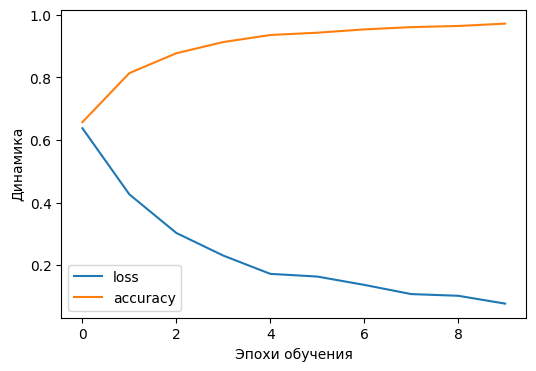

In [ ]:
plt.figure(figsize = (6, 4))
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.xlabel('Эпохи обучения')
plt.ylabel('Динамика')
plt.legend()
plt.show()

In [ ]:
# Выполняем предикт

pred = model_1.predict([x_test], verbose=1)
print()
pred

102/102 [==============================] - 1s 4ms/step



array([[0.76374906],
       [0.96029997],
       [0.9998616 ],
       ...,
       [0.99054   ],
       [0.9699725 ],
       [0.8964545 ]], dtype=float32)

In [ ]:
# Создаем таблицу с предсказаниями

test_pred_df = pd.DataFrame({'Text': x_test, 'Prediction': pred.squeeze()})
# Добавляем столбец с предсказанными классами (0 или 1) на основе порога вероятности Т = 0.5
test_pred_df['Predicted_Class'] = (test_pred_df['Prediction'] >= 0.5).astype(int)

test_pred_df

,Text,Prediction,Predicted_Class
0,Just happened a terrible car crash,0.763749,1
1,"Heard about #earthquake is different cities, s...",0.960300,1
2,"there is a forest fire at spot pond, geese are...",0.999862,1
3,Apocalypse lighting. #Spokane #wildfires,0.999875,1
4,Typhoon Soudelor kills 28 in China and Taiwan,0.999998,1
...,...,...,...
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0.941012,1
3259,Storm in RI worse than last hurricane. My city...,0.996315,1
3260,Green Line derailment in Chicago http://t.co/U...,0.990540,1
3261,MEG issues Hazardous Weather Outlook (HWO) htt...,0.969972,1


In [ ]:
test_loss, test_accuracy = clf_1.evaluate(x_train2, y_train, verbose=1)
print(f"Значения средней ошибки и точность модели на тестовом наборе: {test_loss :.4f} {test_accuracy :.4f}")

238/238 [==============================] - 2s 7ms/step - loss: 0.0567 - accuracy: 0.9775
Значения средней ошибки и точность модели на тестовом наборе: 0.056672 0.977538


#**Русский язык**

**ak.TextClassifier**

---

Автоперевод на русский язык

In [ ]:
clf_2 = ak.TextClassifier(
        max_trials=3,
        overwrite=True,
        seed=42,
        num_classes=2,
        multi_label=False,
        metrics=["accuracy"],
        objective="val_loss",
        loss = 'binary_crossentropy'
        )

history = clf_2.fit(
          x_train_rus2, y_train_rus,
          epochs=10,
          batch_size=32,
          validation_split=0.2,
)

Trial 3 Complete [00h 00m 34s]

Best val_loss So Far: 0.5249025821685791
Total elapsed time: 00h 01m 54s
Epoch 1/10
238/238 [==============================] - 14s 52ms/step - loss: 0.6503 - accuracy: 0.6476
Epoch 2/10
238/238 [==============================] - 2s 10ms/step - loss: 0.4456 - accuracy: 0.8056
Epoch 3/10
238/238 [==============================] - 2s 9ms/step - loss: 0.3289 - accuracy: 0.8654
Epoch 4/10
238/238 [==============================] - 2s 9ms/step - loss: 0.2557 - accuracy: 0.9042
Epoch 5/10
238/238 [==============================] - 2s 8ms/step - loss: 0.2030 - accuracy: 0.9216
Epoch 6/10
238/238 [==============================] - 2s 8ms/step - loss: 0.1748 - accuracy: 0.9330
Epoch 7/10
238/238 [==============================] - 2s 7ms/step - loss: 0.1431 - accuracy: 0.9425
Epoch 8/10
238/238 [==============================] - 2s 7ms/step - loss: 0.1223 - accuracy: 0.9527
Epoch 9/10
238/238 [==============================] - 2s 8ms/step - loss: 0.0996 - accuracy:

In [ ]:
model_1 = clf_2.export_model()
model_1.save('model_text_1.keras')
model_1.summary()

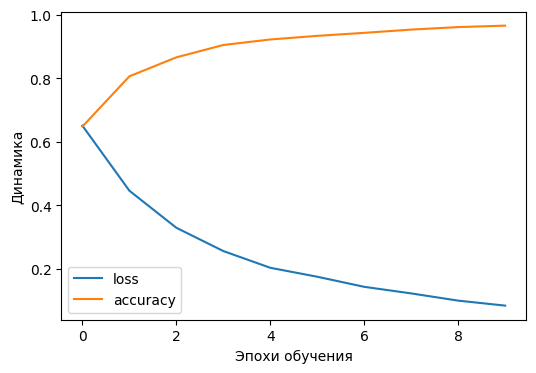

In [ ]:
plt.figure(figsize = (6, 4))
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.xlabel('Эпохи обучения')
plt.ylabel('Динамика')
plt.legend()
plt.show()

In [ ]:
pred_rus = model_1.predict([x_test_rus], verbose=1)

102/102 [==============================] - 0s 3ms/step


In [ ]:
test_pred_rus_df = pd.DataFrame({'Text': x_test_rus, 'Prediction': pred_rus.squeeze()})
test_pred_rus_df['Predicted_Class'] = (test_pred_rus_df['Prediction'] >= 0.5).astype(int)

test_pred_rus_df

,Text,Prediction,Predicted_Class
0,Только что произошла ужасная автокатастрофа,0.987962,1
1,"Слышали о #землетрясении в разных городах, буд...",0.483666,0
2,"на пруду лесной пожар, гуси перебегают улицу, ...",0.984027,1
3,Апокалиптическое освещение. #Спокан #лесные по...,0.999102,1
4,Тайфун Суделор унес жизни 28 человек в Китае и...,0.541245,1
...,...,...,...
3258,СЕЙСЕМАЛЬНАЯ БЕЗОПАСНОСТЬ ЛОС-АНДЖЕЛЕС ÛÒ БЕЗО...,0.925893,1
3259,Шторм в РИ сильнее прошлого урагана. Мой город...,0.999535,1
3260,Крушение зеленой линии в Чикаго http://t.co/Ut...,0.962046,1
3261,MEG выпускает прогноз опасной погоды (HWO) htt...,0.687889,1


In [ ]:
test_loss, test_accuracy = clf_2.evaluate(x_train_rus2, y_train_rus, verbose=1)
print(f"Значения средней ошибки и точность модели на тестовом наборе: {test_loss :.4f} {test_accuracy :.4f}")

238/238 [==============================] - 3s 8ms/step - loss: 0.0678 - accuracy: 0.9716
Значения средней ошибки и точность модели на тестовом наборе: 0.0678 0.9716


**Выводы**


---

В целом, кажется, паритет в двух запусках.

Автоперевод вполне неплох по качеству, учитывая, что и в твиттере пишут далеко не писатели.

Думаю, просто увеличением эпох и колбэком можно было бы обе модели довести до 99,9%.

Однако, как всегда, для более обоснованных выводов, с чем лучше или хуже справляется AutoKeras, конечно, нужно набрать статистику экспериментов, по два раза - мало.

In [ ]:
mod = ['Англ (1)', 'Рус (1)', 'Англ (2)', 'Рус (2)']
los = [0.0121, 0.0140, 0.0566, 0.0678]
accur = [0.9930, 0.9940, 0.9775, 0.9716]
size = [1000, 1000, 7613, 7613]
mt = [3, 3, 3, 3]
ep = [10, 10, 10, 10]
bs = [16, 16, 32, 32]
time = ['02m 33s СPU', '02m 10s СPU', '02m 34s GPU', '01m 54s GPU']

In [ ]:
# Создайте итоговую таблицу

tab = pd.DataFrame(data={"Модель": mod, "Ошибка": los, "Точность": accur, "Размер": size, "max_trials": mt, "Эпохи": ep, "batch-size": bs, "Время": time})

pd.options.display.float_format = '{:.4f}'.format

# Лучшая модель меряется по точности
tab = tab.sort_values("Точность", ascending=False).set_index('Модель')
numeric_columns = ['Ошибка', 'Точность', 'Размер', 'max_trials', 'Эпохи', 'batch-size', "Время"]

styles = [dict(selector="caption", props=[("font-size", "100%"),
                                         ("font-weight", "bold"),
                                         ("text-align", "center")]),
          dict(selector="th", props=[("width", "100px"), ("text-align", "center")]),
          dict(selector="td", props=[("width", "100px"), ("text-align", "center")])]

tab_AK = (tab
          .style
          .set_caption('<span style="font-size: 130%;">Результаты экспериментов</span>')
          .set_table_styles(styles)
          .format(precision=4, subset=numeric_columns)
          .highlight_max(color='yellowgreen', subset=['Ошибка', 'Точность'])
          .highlight_min(color='coral', subset=['Ошибка', 'Точность'])
        )

display(tab_AK)

,Ошибка,Точность,Размер,max_trials,Эпохи,batch-size,Время
Модель,,,,,,,
Рус (1),0.0140,0.9940,1000,3,10,16,02m 10s СPU
Англ (1),0.0121,0.9930,1000,3,10,16,02m 33s СPU
Англ (2),0.0566,0.9775,7613,3,10,32,02m 34s GPU
Рус (2),0.0678,0.9716,7613,3,10,32,01m 54s GPU
